In [1]:
import pandas as pd
import numpy as np

from datetime import date,datetime
from dateutil import parser

from functools import reduce
import re

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
!ls

BTC_USD_CoinDesk.csv GOLDAMGBD228NLBM.csv SP500.csv
DCOILWTICO.csv       PS3_Q2-Copy1.ipynb
DEXUSEU.csv          PS3_Q2.ipynb


## Question 3

In [3]:
def dateTimeConverter(x):
    r = datetime.strptime(x,"%Y-%m-%d")
    return r

def replace_illegal_char(x):
    if re.match('^[\d]+(.\d+)?$',x)==None:
        return np.nan
    else:
        return float(x)

In [4]:
bitcoind_data = pd.read_csv("BTC_USD_CoinDesk.csv")
bitcoind_data['Bitcoin_Price'] = bitcoind_data['Closing Price (USD)']
bitcoind_data = bitcoind_data[['Date','Bitcoin_Price']]

In [5]:
gold_data = pd.read_csv("GOLDAMGBD228NLBM.csv")
gold_data['DATE'] = gold_data['DATE'].apply(lambda x : dateTimeConverter(x))
gold_data['Gold_Price'] = gold_data['GOLDAMGBD228NLBM'].apply(lambda x : replace_illegal_char(x))
gold_data = gold_data[['DATE','Gold_Price']]

In [6]:
exchange_data = pd.read_csv("DEXUSEU.csv")
exchange_data['DATE'] = exchange_data['DATE'].apply(lambda x : dateTimeConverter(x))
exchange_data['Exchange_Value'] = exchange_data['DEXUSEU'].apply(lambda x: replace_illegal_char(x))
exchange_data = exchange_data[['DATE','Exchange_Value']]

In [7]:
sp500_data = pd.read_csv("SP500.csv")
sp500_data['DATE'] = sp500_data['DATE'].apply(lambda x : dateTimeConverter(x))
sp500_data['SP500'] = sp500_data['SP500'].apply(lambda x : replace_illegal_char(x))
sp500_data = sp500_data[['DATE','SP500']]

In [8]:
oil_data = pd.read_csv('DCOILWTICO.csv')
oil_data['DATE'] = oil_data['DATE'].apply(lambda x : dateTimeConverter(x))
oil_data['Oil_Price'] = oil_data['DCOILWTICO'].apply(lambda x: replace_illegal_char(x))
oil_data = oil_data[['DATE','Oil_Price']]

In [9]:
bitcoind_data["DATE"] = bitcoind_data["Date"].apply(lambda x : datetime(parser.parse(x).year,parser.parse(x).month,parser.parse(x).day))
bitcoind_data.drop('Date',axis=1,inplace=True)

In [10]:
df_final = reduce(lambda left,right: pd.merge(left,right,on='DATE'), [bitcoind_data,gold_data,exchange_data,sp500_data,oil_data])

In [11]:
df_final.fillna(method='ffill',inplace=True)
df_final.set_index('DATE',inplace=True)

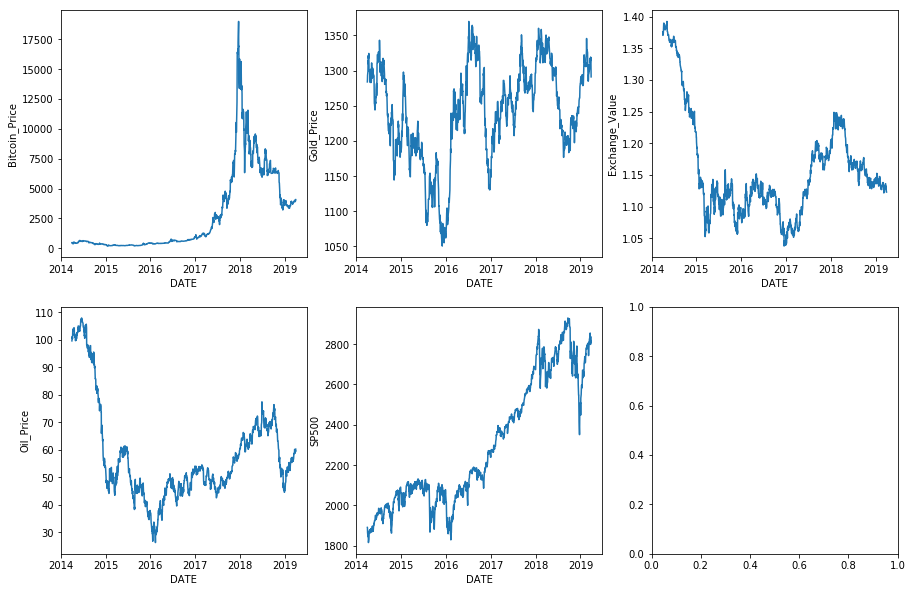

In [12]:
f, axes = plt.subplots(2, 3,figsize=(15,10))

sns.lineplot(x='DATE',y='Bitcoin_Price',data=df_final.reset_index(),ax=axes[0,0])

sns.lineplot(x='DATE',y='Gold_Price',data=df_final.reset_index(),ax=axes[0,1])

sns.lineplot(x='DATE',y='Exchange_Value',data=df_final.reset_index(),ax=axes[0,2])

sns.lineplot(x='DATE',y='Oil_Price',data=df_final.reset_index(),ax=axes[1,0])

sns.lineplot(x='DATE',y='SP500',data=df_final.reset_index(),ax=axes[1,1])

## OLS before differencing and  smoothing

In [13]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [14]:
X = df_final.drop(['Bitcoin_Price'],axis=1)

In [15]:
X = sm.add_constant(X)
y = df_final['Bitcoin_Price']


In [16]:
model = sm.OLS(y,X)

In [17]:
res = model.fit()

In [18]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          Bitcoin_Price   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     994.9
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:49:25   Log-Likelihood:                -11530.
No. Observations:                1300   AIC:                         2.307e+04
Df Residuals:                    1295   BIC:                         2.310e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.998e+04   1261.271    -31.

# KPSS Test for stationarity

In [19]:
from statsmodels.tsa.stattools import kpss

In [20]:
kpss(X['Exchange_Value'].diff(1).fillna(0))[1]

0.07015841364529896

In [21]:
def return_lag_map(X):
    converge_map = {}
    for col in X.columns:
        if col!="Const":
            for lag in range(1,100):
                if float(kpss(X[col].diff(lag).fillna(0))[1])>=0.05:
                    print('converged for {} at lag {}'.format(col,lag))
                    converge_map[col] = lag
                    break
                else:
                    continue
        else:
            continue
    return converge_map
            
            
    

In [22]:
def take_difference(X,converge_map):
    for col in X.columns:
        if col!='const':
            X[col] = X[col].diff(converge_map[col])
        else:
            continue
    return X

In [23]:
X['Bitcoin_Price'] = y
converge_map = return_lag_map(X)

converged for Gold_Price at lag 1
converged for Exchange_Value at lag 1
converged for SP500 at lag 1
converged for Oil_Price at lag 1
converged for Bitcoin_Price at lag 1


In [24]:
converge_map

{'Gold_Price': 1,
 'Exchange_Value': 1,
 'SP500': 1,
 'Oil_Price': 1,
 'Bitcoin_Price': 1}

In [25]:
X_diff = take_difference(X,converge_map)
y_diff = X_diff['Bitcoin_Price']

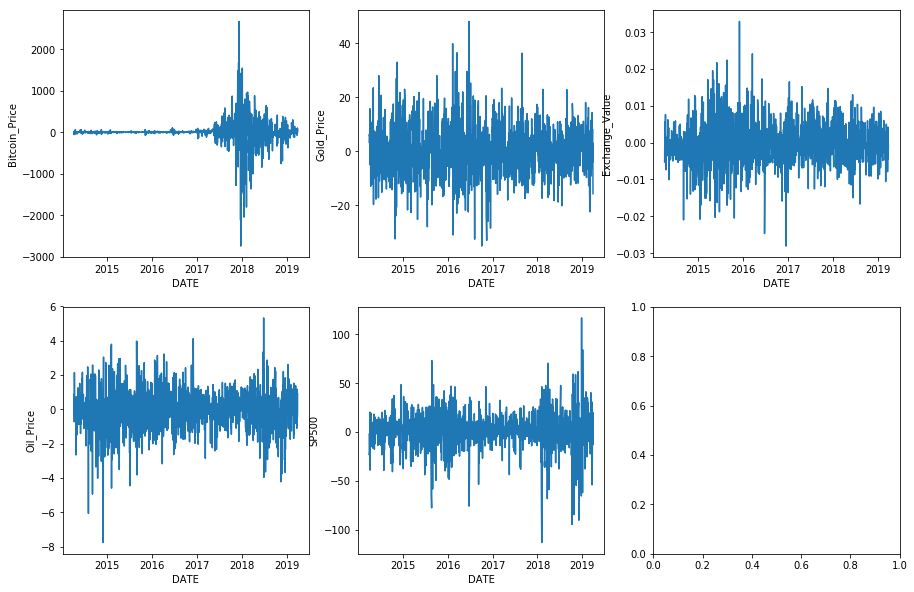

In [26]:
f, axes = plt.subplots(2, 3,figsize=(15,10))

X_diff_plot = X_diff

sns.lineplot(x='DATE',y='Bitcoin_Price',data=X_diff_plot.reset_index(),ax=axes[0,0])

sns.lineplot(x='DATE',y='Gold_Price',data=X_diff_plot.reset_index(),ax=axes[0,1])

sns.lineplot(x='DATE',y='Exchange_Value',data=X_diff_plot.reset_index(),ax=axes[0,2])

sns.lineplot(x='DATE',y='Oil_Price',data=X_diff_plot.reset_index(),ax=axes[1,0])

sns.lineplot(x='DATE',y='SP500',data=X_diff_plot.reset_index(),ax=axes[1,1])

# OLS after differencing

In [27]:
from statsmodels.regression.linear_model import OLS


In [28]:
X_diff.fillna(0,inplace=True)

In [29]:
y_diff.fillna(0,inplace=True)

In [30]:
diff_model = OLS(np.asarray(y),X_diff.drop(['Bitcoin_Price'],axis=1))

In [31]:
diff_res = diff_model.fit()

In [32]:
print(diff_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7563
Date:                Wed, 24 Apr 2019   Prob (F-statistic):              0.554
Time:                        19:49:27   Log-Likelihood:                -12442.
No. Observations:                1300   AIC:                         2.489e+04
Df Residuals:                    1295   BIC:                         2.492e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2709.2380     96.568     28.

##  Removing Data Before 2017

In [120]:
def return_data_after_2017(X,y):
    bool_index = [x.year>2017 for x in X.index]
    
    X = X.loc[bool_index,:]
    y = y[bool_index]
    return X.drop("Bitcoin_Price",axis=1),y
    

In [121]:
X_after_2017,y_after_2017 = return_data_after_2017(X,y)

In [122]:
X_after_2017_diff,y_after_2017_diff = return_data_after_2017(X_diff,y_diff)

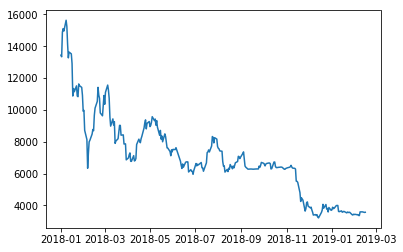

In [123]:
plt.plot(y_after_2017)

## ACF and PACF

In [124]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

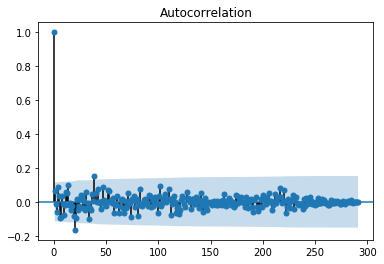

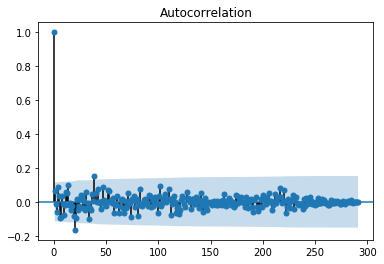

In [125]:
plot_acf(y_after_2017_diff)

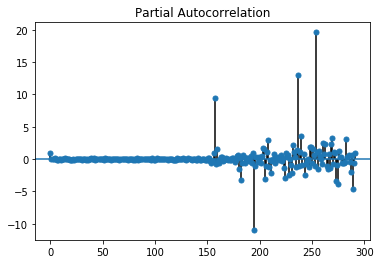

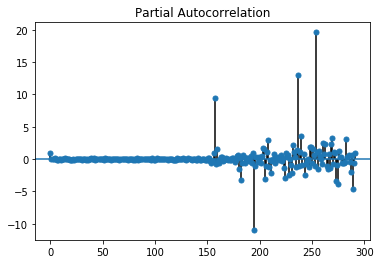

In [126]:
plot_pacf(y_after_2017_diff)

## Fitting ARIMA

In [127]:
from statsmodels.tsa.arima_model import ARIMA
y_for_arima = y_after_2017

In [136]:
s = y_after_2017_diff[:-30]

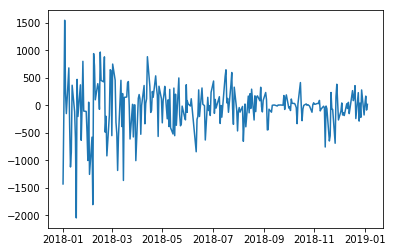

In [137]:
plt.plot(s)

In [130]:
p_list = list(np.arange(0,10,1))
q_list = list(np.arange(0,10,1))
d_list = [1,2]
pqd_aic_map = {}
for p in p_list:
    for q in q_list:
        for d in d_list:  
            try:
                model = ARIMA(s,order=(p,d,q))
                pqd_aic_map[(p,d,q)] = model.fit().aic
                print('fitted with parameters:{} with aic:{}'.format((p,d,q),pqd_aic_map[(p,d,q)]))
            except ValueError:
                pqd_aic_map[(p,d,q)] = None
                print('could not apply arima for {}'.format((p,d,q)))
            except np.linalg.LinAlgError:
                pqd_aic_map[(p,d,q)] = None
                print('could not apply arima for {}'.format((p,d,q)))
                
            
            


fitted with parameters:(0, 1, 0) with aic:4490.947939048471
fitted with parameters:(0, 2, 0) with aic:4782.652948894505
fitted with parameters:(0, 1, 1) with aic:4321.705077066376
fitted with parameters:(0, 2, 1) with aic:4484.136373870815
fitted with parameters:(0, 1, 2) with aic:4322.38081692291
could not apply arima for (0, 2, 2)
could not apply arima for (0, 1, 3)
could not apply arima for (0, 2, 3)
could not apply arima for (0, 1, 4)
could not apply arima for (0, 2, 4)
could not apply arima for (0, 1, 5)
could not apply arima for (0, 2, 5)
could not apply arima for (0, 1, 6)
could not apply arima for (0, 2, 6)
could not apply arima for (0, 1, 7)
could not apply arima for (0, 2, 7)
could not apply arima for (0, 1, 8)
could not apply arima for (0, 2, 8)
could not apply arima for (0, 1, 9)
could not apply arima for (0, 2, 9)
fitted with parameters:(1, 1, 0) with aic:4426.708209564793
fitted with parameters:(1, 2, 0) with aic:4616.538523150244
fitted with parameters:(1, 1, 1) with aic

/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(2, 2, 4) with aic:4310.7064862415955
could not apply arima for (2, 1, 5)
could not apply arima for (2, 2, 5)
could not apply arima for (2, 1, 6)
could not apply arima for (2, 2, 6)
could not apply arima for (2, 1, 7)
could not apply arima for (2, 2, 7)
could not apply arima for (2, 1, 8)
could not apply arima for (2, 2, 8)
could not apply arima for (2, 1, 9)
could not apply arima for (2, 2, 9)
fitted with parameters:(3, 1, 0) with aic:4373.426087372223
fitted with parameters:(3, 2, 0) with aic:4512.8324956899005
fitted with parameters:(3, 1, 1) with aic:4325.1930444082245
fitted with parameters:(3, 2, 1) with aic:4368.943036425635
fitted with parameters:(3, 1, 2) with aic:4326.220412462048
fitted with parameters:(3, 2, 2) with aic:nan
could not apply arima for (3, 1, 3)
could not apply arima for (3, 2, 3)
could not apply arima for (3, 1, 4)


/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(3, 2, 4) with aic:4313.041447182826
could not apply arima for (3, 1, 5)
could not apply arima for (3, 2, 5)
could not apply arima for (3, 1, 6)
could not apply arima for (3, 2, 6)
could not apply arima for (3, 1, 7)
could not apply arima for (3, 2, 7)
could not apply arima for (3, 1, 8)
could not apply arima for (3, 2, 8)
could not apply arima for (3, 1, 9)
could not apply arima for (3, 2, 9)
fitted with parameters:(4, 1, 0) with aic:4364.060770865827
fitted with parameters:(4, 2, 0) with aic:4460.450754929652
fitted with parameters:(4, 1, 1) with aic:4324.3624070988235
fitted with parameters:(4, 2, 1) with aic:4359.984093085335
could not apply arima for (4, 1, 2)


/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(4, 2, 2) with aic:4370.063810546739
could not apply arima for (4, 1, 3)
fitted with parameters:(4, 2, 3) with aic:4329.717997878588
could not apply arima for (4, 1, 4)
fitted with parameters:(4, 2, 4) with aic:4314.615907749665
could not apply arima for (4, 1, 5)
could not apply arima for (4, 2, 5)
could not apply arima for (4, 1, 6)
could not apply arima for (4, 2, 6)
could not apply arima for (4, 1, 7)
could not apply arima for (4, 2, 7)
could not apply arima for (4, 1, 8)
could not apply arima for (4, 2, 8)
could not apply arima for (4, 1, 9)
could not apply arima for (4, 2, 9)
fitted with parameters:(5, 1, 0) with aic:4365.486948378809
fitted with parameters:(5, 2, 0) with aic:4444.292534729843
fitted with parameters:(5, 1, 1) with aic:4326.202716292291
fitted with parameters:(5, 2, 1) with aic:4361.5012611288075
fitted with parameters:(5, 1, 2) with aic:4326.397414724813
fitted with parameters:(5, 2, 2) with aic:4363.477354561874
could not apply arima for (

/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(5, 2, 4) with aic:4340.489645333393
could not apply arima for (5, 1, 5)
could not apply arima for (5, 2, 5)
could not apply arima for (5, 1, 6)
could not apply arima for (5, 2, 6)
could not apply arima for (5, 1, 7)
could not apply arima for (5, 2, 7)
could not apply arima for (5, 1, 8)
could not apply arima for (5, 2, 8)
could not apply arima for (5, 1, 9)
could not apply arima for (5, 2, 9)
fitted with parameters:(6, 1, 0) with aic:4364.678053570924
fitted with parameters:(6, 2, 0) with aic:4441.421586604928
fitted with parameters:(6, 1, 1) with aic:4323.993621828917
fitted with parameters:(6, 2, 1) with aic:4360.889169100235
fitted with parameters:(6, 1, 2) with aic:4325.203513370918


/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(6, 2, 2) with aic:4325.363836091938
could not apply arima for (6, 1, 3)


/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(6, 2, 3) with aic:4366.295699534407
could not apply arima for (6, 1, 4)


/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(6, 2, 4) with aic:4379.656996078678
could not apply arima for (6, 1, 5)
could not apply arima for (6, 2, 5)
could not apply arima for (6, 1, 6)
could not apply arima for (6, 2, 6)
could not apply arima for (6, 1, 7)
could not apply arima for (6, 2, 7)
could not apply arima for (6, 1, 8)
could not apply arima for (6, 2, 8)
could not apply arima for (6, 1, 9)
could not apply arima for (6, 2, 9)
fitted with parameters:(7, 1, 0) with aic:4354.762052105374
fitted with parameters:(7, 2, 0) with aic:4426.830289511994
fitted with parameters:(7, 1, 1) with aic:4324.655932892585
fitted with parameters:(7, 2, 1) with aic:4351.374177030132
fitted with parameters:(7, 1, 2) with aic:4325.901632971553


/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(7, 2, 2) with aic:4325.854566685541
fitted with parameters:(7, 1, 3) with aic:4331.806343857177


/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(7, 2, 3) with aic:4328.255047081356
fitted with parameters:(7, 1, 4) with aic:4332.152468031115


/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(7, 2, 4) with aic:4370.230944831366
fitted with parameters:(7, 1, 5) with aic:4337.118787239477
could not apply arima for (7, 2, 5)
could not apply arima for (7, 1, 6)
could not apply arima for (7, 2, 6)
could not apply arima for (7, 1, 7)
could not apply arima for (7, 2, 7)
could not apply arima for (7, 1, 8)
could not apply arima for (7, 2, 8)
could not apply arima for (7, 1, 9)
could not apply arima for (7, 2, 9)
fitted with parameters:(8, 1, 0) with aic:4354.9309152602
fitted with parameters:(8, 2, 0) with aic:4413.599610908837
fitted with parameters:(8, 1, 1) with aic:4325.679721101561
fitted with parameters:(8, 2, 1) with aic:4351.69663876146
fitted with parameters:(8, 1, 2) with aic:4327.53526148119
fitted with parameters:(8, 2, 2) with aic:4352.653050432324
fitted with parameters:(8, 1, 3) with aic:4323.924748379973
could not apply arima for (8, 2, 3)
could not apply arima for (8, 1, 4)
could not apply arima for (8, 2, 4)


/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fitted with parameters:(8, 1, 5) with aic:4333.8752974054905
could not apply arima for (8, 2, 5)
could not apply arima for (8, 1, 6)
could not apply arima for (8, 2, 6)
could not apply arima for (8, 1, 7)
could not apply arima for (8, 2, 7)
could not apply arima for (8, 1, 8)
could not apply arima for (8, 2, 8)
could not apply arima for (8, 1, 9)
could not apply arima for (8, 2, 9)
fitted with parameters:(9, 1, 0) with aic:4356.564680521428
fitted with parameters:(9, 2, 0) with aic:4413.222345841965
fitted with parameters:(9, 1, 1) with aic:4327.078419807266
could not apply arima for (9, 2, 1)
fitted with parameters:(9, 1, 2) with aic:4329.640883271045
could not apply arima for (9, 2, 2)
fitted with parameters:(9, 1, 3) with aic:4322.9318611039325
could not apply arima for (9, 2, 3)
fitted with parameters:(9, 1, 4) with aic:4333.728592485706
could not apply arima for (9, 2, 4)
fitted with parameters:(9, 1, 5) with aic:4335.894860108466
could not apply arima for (9, 2, 5)
could not appl

/Users/pavankumarboinapalli/DSWorkspace/ProgramFiles/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [131]:
pqd_aic_map

{(0, 1, 0): 4490.947939048471,
 (0, 2, 0): 4782.652948894505,
 (0, 1, 1): 4321.705077066376,
 (0, 2, 1): 4484.136373870815,
 (0, 1, 2): 4322.38081692291,
 (0, 2, 2): None,
 (0, 1, 3): None,
 (0, 2, 3): None,
 (0, 1, 4): None,
 (0, 2, 4): None,
 (0, 1, 5): None,
 (0, 2, 5): None,
 (0, 1, 6): None,
 (0, 2, 6): None,
 (0, 1, 7): None,
 (0, 2, 7): None,
 (0, 1, 8): None,
 (0, 2, 8): None,
 (0, 1, 9): None,
 (0, 2, 9): None,
 (1, 1, 0): 4426.708209564793,
 (1, 2, 0): 4616.538523150244,
 (1, 1, 1): 4322.407685283194,
 (1, 2, 1): None,
 (1, 1, 2): 4324.380244429044,
 (1, 2, 2): None,
 (1, 1, 3): 4324.5654871791185,
 (1, 2, 3): None,
 (1, 1, 4): 4325.871457566042,
 (1, 2, 4): 4326.376894934958,
 (1, 1, 5): None,
 (1, 2, 5): None,
 (1, 1, 6): None,
 (1, 2, 6): None,
 (1, 1, 7): None,
 (1, 2, 7): None,
 (1, 1, 8): None,
 (1, 2, 8): None,
 (1, 1, 9): None,
 (1, 2, 9): None,
 (2, 1, 0): 4406.142958994058,
 (2, 2, 0): 4568.208724979358,
 (2, 1, 1): 4324.324392959436,
 (2, 2, 1): None,
 (2, 1, 2): 4

In [132]:
model = ARIMA(y_for_arima,order=(2,2,4))
arima_res = model.fit()

In [133]:
arima_res.aic

4289.248705766368

In [134]:
print(arima_res.summary())

                             ARIMA Model Results                              
Dep. Variable:       D2.Bitcoin_Price   No. Observations:                  290
Model:                 ARIMA(2, 2, 4)   Log Likelihood               -2136.624
Method:                       css-mle   S.D. of innovations            376.251
Date:                Wed, 24 Apr 2019   AIC                           4289.249
Time:                        20:10:01   BIC                           4318.608
Sample:                             2   HQIC                          4301.011
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.2198      0.279      0.787      0.432      -0.328       0.767
ar.L1.D2.Bitcoin_Price    -0.3948      0.029    -13.805      0.000      -0.451      -0.339
ar.L

(array([  2.,   3.,   7.,  19.,  69., 138.,  40.,   7.,   4.,   1.]),
 array([-1773.63411299, -1431.72068178, -1089.80725058,  -747.89381937,
         -405.98038817,   -64.06695696,   277.84647424,   619.75990545,
          961.67333666,  1303.58676786,  1645.50019907]),
 <a list of 10 Patch objects>)

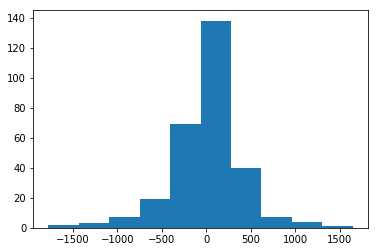

In [135]:
plt.hist(arima_res.resid)

In [109]:
forcast = arima_res.forecast(30)[0]

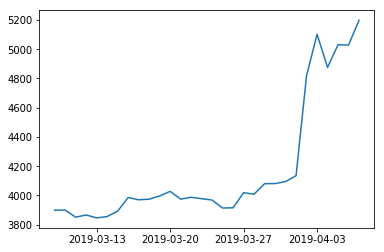

In [110]:
plt.plot(bitcoind_data.tail(30)['DATE'],bitcoind_data.tail(30)['Bitcoin_Price'])

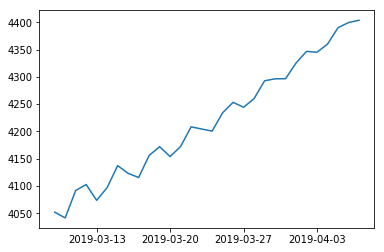

In [111]:
plt.plot(bitcoind_data.tail(30)['DATE'],forcast)

In [103]:
from statsmodels.tsa.api import VAR

In [104]:
model = VAR(X_diff.drop(['Bitcoin_Price','const'],axis=1))

In [105]:
res = model.fit()

In [106]:
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Apr, 2019
Time:                     20:01:55
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.371645
Nobs:                     1299.00    HQIC:                  0.321919
Log likelihood:          -7542.49    FPE:                    1.33918
AIC:                     0.292055    Det(Omega_mle):         1.31876
--------------------------------------------------------------------
Results for equation Gold_Price
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.116658         0.253073            0.461           0.645
L1.Gold_Price            -0.024596         0.027716           -0.887           0.375
L1.Exchange_Value       339.438789     

In [107]:
X_diff.drop(['Bitcoin_Price','const'],axis=1)

,Gold_Price,Exchange_Value,SP500,Oil_Price
DATE,,,,
2014-04-02,0.00,0.0000,0.00,0.00
2014-04-03,3.25,-0.0053,-2.13,0.69
2014-04-04,6.25,-0.0004,-23.68,0.87
2014-04-07,5.50,0.0041,-20.05,-0.73
2014-04-08,15.75,0.0057,6.92,2.14
2014-04-09,-5.00,0.0014,20.22,0.98
2014-04-10,11.75,0.0076,-39.10,-0.18
2014-04-11,-4.25,0.0006,-17.39,0.31
2014-04-14,7.25,-0.0074,14.92,0.37
